In [68]:
import numpy as np
import pandas as pd
import os
import datetime
from collections import OrderedDict
import datetime as dt
import QuantLib as ql

File collection

In [2]:
daily_chains = OrderedDict()
files = sorted(os.listdir('spy_data'))

for file in files:
    if file[-4:] == '.csv':
        df = pd.read_csv('spy_data/' + file)        
        
        # moving to datetime and making features
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['quote_date'] = df['quote_datetime'][0].date()
        df['quote_date'] = pd.to_datetime(df['quote_date'])
        
        # getting only 4:00 quotes
        eod = datetime.datetime.combine(df['quote_datetime'][0].date(), datetime.time(16,0, 0))
        df = df.loc[df['quote_datetime'] == eod]
        
        # getting time to expiration and moneyness
        df['T'] = df['expiration'] - df['quote_date']
        df['T'] = df['T'].dt.days
        
        # filtering for research paper criteria
        df = df.loc[df['close']!=0]
                    
        calls = df.loc[df['option_type']=='C'][['quote_date', 'expiration', 'T','implied_volatility', 'active_underlying_price', 'strike', 'bid', 'ask']]
        puts = df.loc[df['option_type']=='P'][['quote_date','expiration', 'T', 'implied_volatility', 'active_underlying_price', 'strike', 'bid', 'ask']]
        
        daily_chains[file[-14:-4]] = {'calls':calls, 'puts':puts}

NameError: name 'OrderedDict' is not defined

In [80]:
def time_to_div(day):
    """fraction of years until next dividend"""
    
    # get offset 
    divs = ["09-15", "06-16", "03-17", "12-16"]
    div_dates = sorted([dt.datetime.strptime(f'{day.year}-{date}', '%Y-%m-%d') for date in divs])
    
    # get next dividend 
    for date in div_dates:
        if day <= date:
            return (date - day).days / 365
    
    return (div_dates[0].replace(year=day.year + 1) - day).days / 365

American pricing with QuantLib

In [314]:
def price_w_ql(quote, opt_type):

    exp = quote['expiration']
    day = quote['quote_date']

    # option data
    maturity_date = ql.Date(exp.day, exp.month, exp.year)
    spot_price = quote['active_underlying_price']
    strike_price = quote['strike']
    volatility = quote['implied_volatility'] # the historical vols or implied vols
    dividend_rate =  0.0141
    if opt_type == "call":
        option_type = ql.Option.Call
    elif opt_type == "put":
        option_type = ql.Option.Put

    risk_free_rate = 0.054
    div_yield = 0.0141
    day_count = ql.Actual365Fixed()
    #calendar = ql.UnitedStates()
    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
    calculation_date = ql.Date(day.day, day.month, day.year)
    ql.Settings.instance().evaluationDate = calculation_date
    
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    settlement = calculation_date

    am_exercise = ql.AmericanExercise(settlement, maturity_date)
    american_option = ql.VanillaOption(payoff, am_exercise)

    spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
    )
    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, risk_free_rate, day_count)
    )
    dividend_yield = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, div_yield, day_count)
    )
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
    )
    bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                            dividend_yield, 
                                            flat_ts, 
                                            flat_vol_ts)
    
    steps = 2500
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    american_option.setPricingEngine(binomial_engine)
    return american_option.NPV()

In [315]:
price_w_ql(daily_chains['2023-10-02']['calls'].iloc[1500], "call")

42.90115252626289

American binomial tree option pricer with discrete dividends

In [156]:
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.1  # risk free rate
sig = 0.2  # diffusion coefficient or volatility

In [158]:
N = 25000  # number of periods or number of time steps
payoff = "put"  # payoff

dT = float(T) / N  # Delta t
u = np.exp(sig * np.sqrt(dT))  # up factor
d = 1.0 / u  # down factor

# yield is the quarterly yield
div = {'yield': 0.003556, 'freq': 0.25, 'offset': time_to_div()}

# get in time T, when dividends occur
div_times = [div['offset']+n*div['freq'] for n in range(int((T-div['offset'])/div['freq'])+1) ]

V = np.zeros(N + 1)  # initialize the price vector
S_T = np.array([(S0 * u**j * d ** (N - j)) for j in range(N + 1)]) 

a = np.exp(r * dT)  # risk free compound return
p = (a - d) / (u - d)  # risk neutral up probability
q = 1.0 - p  # risk neutral down probability

# Determine the number of dividends paid in total
num_dividends = int((T - div['offset']) / div['freq'])
dividend_adjustment = (1 - div['yield']) ** num_dividends
S_T = S_T * dividend_adjustment

if payoff == "call":
    V[:] = np.maximum(S_T - K, 0.0)
elif payoff == "put":
    V[:] = np.maximum(K - S_T, 0.0)

for i in range(N - 1, -1, -1):

        
    V[:-1] = np.exp(-r * dT) * (p * V[1:] + q * V[:-1])  # the price vector is overwritten at each step
    
    S_T = S_T * u  # it is a tricky way to obtain the price at the previous time step

    # if we pass threshold, we can divide by (1-div)
    if div_times:
        if i * dT < div_times[-1]:
            S_T = S_T / (1 - div['yield'])
            div_times.pop(-1)
    
    if payoff == "call":
        V = np.maximum(V, S_T - K)
    elif payoff == "put":
        V = np.maximum(V, K - S_T)
            

print("American BS Tree Price: ", V[0])

American BS Tree Price:  5.0313121291786995


In [316]:
def my_price(quote, opt_type):
    S0 = quote['active_underlying_price'] # spot stock price
    K = quote['strike']  # strike
    T = (test['expiration'] - test['quote_date']).days / 365 # maturity
    r = 0.054  # risk free rate
    sig = quote['implied_volatility']  # volatility
    div = 0.0141
    
    N = 2500  # number of periods or number of time steps
    payoff = opt_type  # payoff

    dT = float(T) / N  # Delta t
    u = np.exp(sig * np.sqrt(dT))  # up factor with divident
    d = 1.0 / u  # down factor

    V = np.zeros(N + 1)  # initialize the price vector
    S_T = np.array([(S0 * u**j * d ** (N - j)) for j in range(N + 1)]) 

    a = np.exp((r - div) * dT)  # risk free compound return
    p = (a - d) / (u - d)  # risk neutral up probability
    q = 1.0 - p  # risk neutral down probability

    if payoff == "call":
        V[:] = np.maximum(S_T - K, 0.0)
    elif payoff == "put":
        V[:] = np.maximum(K - S_T, 0.0)

    for i in range(N - 1, -1, -1):

        V[:-1] = np.exp(-r * dT) * (p * V[1:] + q * V[:-1])  # the price vector is overwritten at each step
        
        S_T = S_T * u  # it is a tricky way to obtain the price at the previous time step

        if payoff == "call":
            V = np.maximum(V, S_T - K)
        elif payoff == "put":
            V = np.maximum(V, K - S_T)
                

    return V[0]

In [1]:
test_day = daily_chains['2023-10-02']['calls'].iloc[700]
#test_day['calls']['T'].unique()
test_day

NameError: name 'daily_chains' is not defined

In [327]:
test_day = daily_chains['2023-10-02']
print(test_day['calls']['T'].unique())

[  0   1   2   3   4   7   8   9  10  11  14  18  25  32  39  46  74  88
 109 137 165 178 263 270 354 364 445 473 536 627 809 837]


In [319]:
print('continuous w ql:', price_w_ql(test, "call"))
print('continuous w mine:', price_w_discrete(test, 'call'))
print('market bid:', test['bid'])
print('market ask:', test['ask'])

continuous w ql: 11.197978672949027
discrete: 11.465948407592396
market bid: 11.54
market ask: 11.6


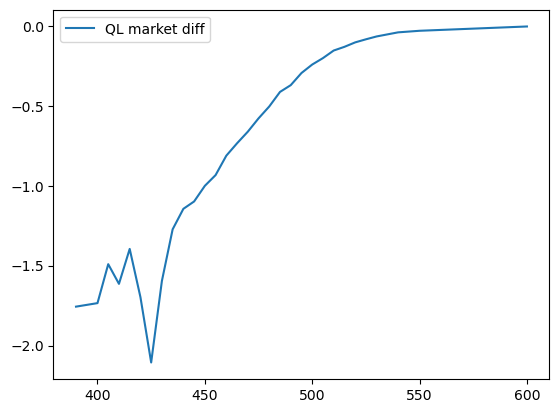

In [334]:
import matplotlib.pyplot as plt

c = test_day['calls']
p = test_day['puts']
c = c.loc[c['T']==263]
p = p.loc[p['T']==263]

c.sort_values(by='strike')
p.sort_values(by='strike')

c_ql = c.apply(lambda row: price_w_ql(row, "call"), axis=1)
#c_dcr = c.apply(lambda row: price_w_discrete(row, "call"), axis=1)
mid = c.apply(lambda row: (row['bid'] + row['ask'])/2, axis=1)

plt.plot(c['strike'], c_ql - mid, label='QL market diff')
#plt.plot(c['strike'], c_dcr - mid, label='My market diff')

plt.legend()
plt.show()

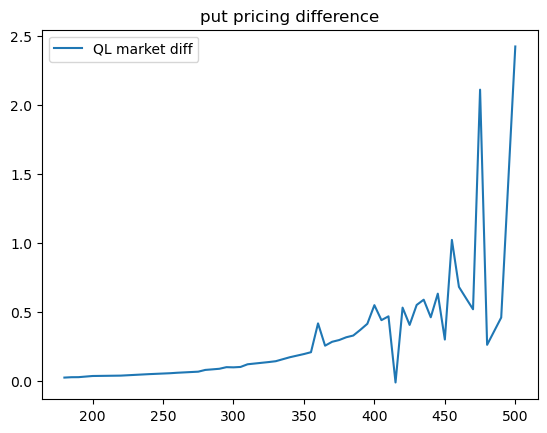

In [335]:
p_ql = p.apply(lambda row: price_w_ql(row, "put"), axis=1)
p_dcr = p.apply(lambda row: price_w_discrete(row, "put"), axis=1)
pmid = p.apply(lambda row: (row['bid'] + row['ask'])/2, axis=1)

plt.plot(p['strike'], p_ql - pmid, label='QL market diff')
#plt.plot(p['strike'], p_dcr - pmid, label='My market diff')

plt.title("put pricing difference")
plt.legend()
plt.show()
